# Matomo Analytics: Comprehensive User Behavior Analysis

This notebook provides a structured analysis of Matomo web analytics data to understand:
1. Data cleaning and preprocessing
2. User vs Bot behavior detection
3. User journey analysis
4. User segmentation through clustering
5. Pattern analysis and recommendations

We'll follow a step-by-step approach to ensure data quality and meaningful insights.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pytz
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Initial Exploration

Let's load and explore the three main Matomo tables:
- `log_visit`: Contains visit-level information
- `log_link_visit_action`: Contains page view and action details
- `log_action`: Contains information about URLs and actions

First, we'll load the data and examine its structure.

In [3]:
# Load the datasets
log_visit = pd.read_csv('exported_tables/matomo_log_visit.csv', on_bad_lines='skip')
log_link_visit = pd.read_csv('exported_tables/matomo_log_link_visit_action.csv', on_bad_lines='skip')
log_action = pd.read_csv('exported_tables/matomo_log_action.csv', on_bad_lines='skip')

# Display basic information about each dataset
print("Dataset Information:")
print("\nlog_visit shape:", log_visit.shape)
print("log_link_visit shape:", log_link_visit.shape)
print("log_action shape:", log_action.shape)

Dataset Information:

log_visit shape: (1000, 60)
log_link_visit shape: (1000, 41)
log_action shape: (1000, 5)


## 2. Data Cleaning and Preprocessing

Let's clean each table separately and then merge them:

1. log_visit cleaning:
   - Remove unnecessary columns
   - Handle missing values
   - Convert timestamps
   
2. log_link_visit cleaning:
   - Remove unused columns
   - Clean action references
   
3. log_action cleaning:
   - Build proper URLs
   - Clean action types

In [4]:
# Clean log_visit table
def clean_log_visit(df):
    # Columns to remove (unnecessary or mostly empty)
    columns_to_drop = [
        'idvisitor', 'config_id', 'location_ip', 'user_id', 'profilable',
        'custom_dimension_1', 'custom_dimension_2', 'custom_dimension_3',
        'custom_dimension_4', 'custom_dimension_5', 'config_browser_engine',
        'config_flash', 'config_java', 'config_pdf', 'config_quicktime',
        'config_realplayer', 'config_silverlight', 'config_windowsmedia',
        'location_latitude', 'location_longitude'
    ]
    
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    
    # Drop unnecessary columns
    df_clean = df_clean.drop(columns=columns_to_drop)
    
    # Convert timestamps to datetime
    df_clean['visit_first_action_time'] = pd.to_datetime(df_clean['visit_first_action_time'])
    df_clean['visit_last_action_time'] = pd.to_datetime(df_clean['visit_last_action_time'])
    
    # Fill missing values
    df_clean['visit_total_time'] = df_clean['visit_total_time'].fillna(0)
    df_clean['visit_total_actions'] = df_clean['visit_total_actions'].fillna(0)
    
    return df_clean

# Clean log_visit
log_visit_clean = clean_log_visit(log_visit)

print("\nRemaining columns:", log_visit_clean.columns.tolist())


Remaining columns: ['idvisit', 'idsite', 'visit_last_action_time', 'visit_first_action_time', 'visit_goal_buyer', 'visit_goal_converted', 'visitor_returning', 'visitor_seconds_since_first', 'visitor_seconds_since_order', 'visitor_count_visits', 'visit_entry_idaction_name', 'visit_entry_idaction_url', 'visit_exit_idaction_name', 'visit_exit_idaction_url', 'visit_total_actions', 'visit_total_interactions', 'visit_total_searches', 'referer_keyword', 'referer_name', 'referer_type', 'referer_url', 'location_browser_lang', 'config_browser_name', 'config_browser_version', 'config_client_type', 'config_device_brand', 'config_device_model', 'config_device_type', 'config_os', 'config_os_version', 'visit_total_events', 'visitor_localtime', 'visitor_seconds_since_last', 'config_resolution', 'config_cookie', 'visit_total_time', 'location_city', 'location_country', 'location_region', 'last_idlink_va']


In [5]:
# Clean log_link_visit table
def clean_log_link_visit(df):
    # Columns to remove
    columns_to_drop = [
        'custom_float', 'search_cat', 'search_count',
        'idaction_product_cat', 'idaction_product_cat2', 'idaction_product_cat3',
        'idaction_product_cat4', 'idaction_product_cat5', 'idaction_product_name',
        'product_price', 'idaction_product_sku', 'custom_dimension_1',
        'custom_dimension_2', 'custom_dimension_3', 'custom_dimension_4',
        'custom_dimension_5', 'idvisitor'
    ]
    
    # Create a copy
    df_clean = df.copy()
    
    # Drop unnecessary columns
    df_clean = df_clean.drop(columns=columns_to_drop)
    
    # Fill missing values in key columns
    df_clean['idaction_url'] = df_clean['idaction_url'].fillna(0).astype(int)
    df_clean['idaction_name'] = df_clean['idaction_name'].fillna(0).astype(int)
    
    return df_clean

# Clean log_link_visit
log_link_visit_clean = clean_log_link_visit(log_link_visit)

print("\nRemaining columns:", log_link_visit_clean.columns.tolist())


Remaining columns: ['idlink_va', 'idsite', 'idvisit', 'idaction_url_ref', 'idaction_name_ref', 'pageview_position', 'server_time', 'idpageview', 'idaction_name', 'idaction_url', 'time_spent_ref_action', 'idaction_event_action', 'idaction_event_category', 'idaction_content_interaction', 'idaction_content_name', 'idaction_content_piece', 'idaction_content_target', 'time_dom_completion', 'time_dom_processing', 'time_network', 'time_on_load', 'time_server', 'time_transfer', 'time_spent']


In [6]:
# Clean and process log_action table
def clean_log_action(df):
    # URL prefix mapping
    url_prefix_map = {
        0: 'http://',
        1: 'http://www.',
        2: 'https://',
        3: 'https://www.'
    }
    
    # Create a copy
    df_clean = df.copy()
    
    # Build full URLs
    def build_full_url(row):
        if row['type'] in [1, 2, 3]:  # URL types
            prefix = url_prefix_map.get(row['url_prefix'], '')
            return prefix + str(row['name'])
        return str(row['name'])
    
    # Create full URL column
    df_clean['full_url'] = df_clean.apply(build_full_url, axis=1)
    
    # Keep only necessary columns
    df_clean = df_clean[['idaction', 'full_url', 'type']]
    
    return df_clean

# Clean log_action
log_action_clean = clean_log_action(log_action)

print("\nSample of cleaned log_action:")
display(log_action_clean.head())


Sample of cleaned log_action:


,idaction,full_url,type
0,1,Vipani | Smart Procurement Platform for the Di...,4
1,2,http://localhost/rfq/buyer/generate-po?quoteId...,1
2,3,http://localhost/rfq/sellers/rfq-list,1
3,4,http://localhost/order-management,1
4,5,http://192.168.9.133/,1


## 3. Data Integration

Now we'll merge the cleaned tables to create a complete dataset for analysis:
1. First, merge log_link_visit with log_action to get full URLs
2. Then merge with log_visit to get visit context
3. Create derived metrics for analysis

In [7]:
# Merge the cleaned datasets
def create_complete_dataset():
    # First merge: log_link_visit with log_action for URLs
    visit_actions = pd.merge(
        log_link_visit_clean,
        log_action_clean,
        left_on='idaction_url',
        right_on='idaction',
        how='left'
    )
    
    # Second merge: Add visit context
    complete_data = pd.merge(
        visit_actions,
        log_visit_clean,
        on='idvisit',
        how='left'
    )
    
    # Create derived metrics
    complete_data['time_per_action'] = complete_data['visit_total_time'] / complete_data['visit_total_actions']
    complete_data['visit_hour'] = complete_data['visit_first_action_time'].dt.hour
    
    return complete_data

# Create complete dataset
complete_data = create_complete_dataset()

print("Complete dataset shape:", complete_data.shape)
print("\nKey columns available:", sorted(complete_data.columns.tolist()))
print("\nSample of complete data:")
display(complete_data.head(2))

Complete dataset shape: (1000, 68)

Key columns available: ['config_browser_name', 'config_browser_version', 'config_client_type', 'config_cookie', 'config_device_brand', 'config_device_model', 'config_device_type', 'config_os', 'config_os_version', 'config_resolution', 'full_url', 'idaction', 'idaction_content_interaction', 'idaction_content_name', 'idaction_content_piece', 'idaction_content_target', 'idaction_event_action', 'idaction_event_category', 'idaction_name', 'idaction_name_ref', 'idaction_url', 'idaction_url_ref', 'idlink_va', 'idpageview', 'idsite_x', 'idsite_y', 'idvisit', 'last_idlink_va', 'location_browser_lang', 'location_city', 'location_country', 'location_region', 'pageview_position', 'referer_keyword', 'referer_name', 'referer_type', 'referer_url', 'server_time', 'time_dom_completion', 'time_dom_processing', 'time_network', 'time_on_load', 'time_per_action', 'time_server', 'time_spent', 'time_spent_ref_action', 'time_transfer', 'type', 'visit_entry_idaction_name', '

,idlink_va,idsite_x,idvisit,idaction_url_ref,idaction_name_ref,pageview_position,server_time,idpageview,idaction_name,idaction_url,...,visitor_seconds_since_last,config_resolution,config_cookie,visit_total_time,location_city,location_country,location_region,last_idlink_va,time_per_action,visit_hour
0,1,1,1,0,0,1,2025-02-21 09:50:35,edNZua,1,2,...,0.0,1920x1080,1.0,844.0,Mumbai,in,MH,NaN,120.571429,9.0
1,2,1,1,2,1,2,2025-02-21 09:50:35,L3xMsC,1,3,...,0.0,1920x1080,1.0,844.0,Mumbai,in,MH,NaN,120.571429,9.0


## 4. Bot Detection Analysis

We'll detect potential bots using multiple indicators:
1. Visit patterns (time between actions)
2. Action frequency
3. Visit timing patterns
4. Browser/device characteristics

We'll create a composite bot score based on these factors.

## 5. User Behavior Analysis

Now that we've identified and filtered out bots, let's analyze real user behavior:
1. Popular pages and entry points
2. User journey patterns
3. Time spent analysis
4. Device and location patterns

### Geographic Analysis and User Behavior Patterns

Let's analyze user behavior patterns by geographic location to understand:
1. Country-specific engagement metrics
2. Device preferences by region
3. Popular content by country
4. Time patterns across different regions

In [9]:
# Analyze user behavior by country
def analyze_geographic_behavior(df):
    # Group by country
    country_metrics = df.groupby('location_country').agg({
        'idvisit': 'count',
        'visit_total_time': 'mean',
        'visit_total_actions': 'mean',
        'visitor_returning': 'mean',
        'config_device_type': lambda x: x.value_counts().index[0]  # most common device
    }).reset_index()
    
    country_metrics.columns = ['country', 'total_visits', 'avg_duration', 
                             'avg_actions', 'return_rate', 'primary_device']
    
    # Sort by total visits
    country_metrics = country_metrics.sort_values('total_visits', ascending=False)
    
    # Calculate percentages for better comparison
    total_visits = country_metrics['total_visits'].sum()
    country_metrics['visit_percentage'] = country_metrics['total_visits'] / total_visits * 100
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Visit distribution
    plt.subplot(2, 2, 1)
    plt.pie(country_metrics.head(5)['visit_percentage'], 
            labels=country_metrics.head(5)['country'],
            autopct='%1.1f%%')
    plt.title('Top 5 Countries by Visit Share')
    
    # Plot 2: Engagement metrics by country
    plt.subplot(2, 2, 2)
    top_10_countries = country_metrics.head(10)
    x = range(len(top_10_countries))
    plt.bar(x, top_10_countries['avg_actions'])
    plt.xticks(x, top_10_countries['country'], rotation=45)
    plt.title('Average Actions by Country (Top 10)')
    plt.ylabel('Average Actions per Visit')
    
    # Plot 3: Return rate by country
    plt.subplot(2, 2, 3)
    plt.bar(x, top_10_countries['return_rate'] * 100)
    plt.xticks(x, top_10_countries['country'], rotation=45)
    plt.title('Return Rate by Country (Top 10)')
    plt.ylabel('Return Rate (%)')
    
    # Plot 4: Device preferences
    device_by_country = df.groupby(['location_country', 'config_device_type']).size().unstack()
    device_by_country_pct = device_by_country.div(device_by_country.sum(axis=1), axis=0)
    device_by_country_pct.head(10).plot(kind='bar', stacked=True, 
                                       ax=plt.subplot(2, 2, 4))
    plt.title('Device Usage by Country (Top 10)')
    plt.xlabel('Country')
    plt.ylabel('Percentage')
    plt.legend(title='Device Type', bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Detailed country analysis
    print("\nDetailed Country Analysis:")
    print("=" * 50)
    for _, row in country_metrics.head(10).iterrows():
        print(f"\n{row['country']}:")
        print(f"- Total Visits: {row['total_visits']:,.0f} ({row['visit_percentage']:.1f}%)")
        print(f"- Avg. Duration: {row['avg_duration']:.1f} seconds")
        print(f"- Avg. Actions: {row['avg_actions']:.1f}")
        print(f"- Return Rate: {row['return_rate']*100:.1f}%")
        print(f"- Primary Device: {row['primary_device']}")
    
    return country_metrics

# Perform geographic analysis
geographic_metrics = analyze_geographic_behavior(human_data)





# Analyze content preferences by region
def analyze_regional_content(df):
    top_countries = df['location_country'].value_counts().head(5).index
    
    for country in top_countries:
        country_data = df[df['location_country'] == country]
        top_pages = country_data['full_url'].value_counts().head(5)
        
        print(f"\nTop Pages for {country}:")
        print("-" * 50)
        for page, count in top_pages.items():
            print(f"{page}: {count:,} views")

# Analyze content preferences
analyze_regional_content(human_data)

NameError: name 'human_data' is not defined

In [10]:
# # Filter out bot traffic
human_data = complete_data[complete_data['bot_score'] <= 0.7].copy()

def analyze_user_behavior(df):
    # === Helper: shorten URLs for plotting ===
    def shorten_url(url):
        if pd.isna(url):
            return ""
        return url.split('//')[-1][:60]  # max 60 chars
    
    df['short_url'] = df['full_url'].apply(shorten_url)

    # === 1. Popular pages analysis ===
    popular_pages = df.groupby('short_url')['idaction'].count().sort_values(ascending=False)
    
    # === 2. Entry pages analysis ===
    entry_pages = df[df['pageview_position'] == 1]['short_url'].value_counts()
    
    # === 3. Hourly visits ===
    hourly_visits = df['visit_hour'].value_counts().reindex(range(24), fill_value=0)
    
    # === 4. Device usage ===
    device_usage = df['config_device_type'].value_counts(normalize=True) * 100
    if len(device_usage) > 6:  # group tiny slices into "Other"
        device_usage = device_usage[device_usage > 1].append(
            pd.Series({'Other': device_usage[device_usage <= 1].sum()})
        )

    # === Plot each chart separately for clarity ===
    
    # 1. Most popular pages
    fig, ax = plt.subplots(figsize=(10, 6))
    popular_pages.head(10).sort_values().plot(kind='barh', ax=ax)
    ax.set_title('Most Popular Pages')
    ax.set_xlabel('Number of Views')
    ax.tick_params(axis='y', labelsize=9)
    plt.tight_layout()
    plt.show()
    
    # 2. Top entry pages
    fig, ax = plt.subplots(figsize=(10, 6))
    entry_pages.head(10).sort_values().plot(kind='barh', ax=ax)
    ax.set_title('Top Entry Pages')
    ax.set_xlabel('Number of Entries')
    ax.tick_params(axis='y', labelsize=9)
    plt.tight_layout()
    plt.show()
    
    # 3. Visits by hour
    fig, ax = plt.subplots(figsize=(10, 4))
    hourly_visits.plot(kind='line', marker='o', ax=ax)
    ax.set_title('Visits by Hour')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Number of Visits')
    ax.set_xticks(range(24))
    plt.tight_layout()
    plt.show()
    
    # 4. Device type distribution
    fig, ax = plt.subplots(figsize=(6, 6))
    device_usage.plot(kind='pie', autopct='%1.1f%%', ax=ax)
    ax.set_ylabel('')
    ax.set_title('Device Type Distribution')
    plt.tight_layout()
    plt.show()

    # === Calculate metrics ===
    avg_visit_duration = df.groupby('idvisit')['visit_total_time'].first().mean()
    avg_pages_per_visit = df.groupby('idvisit')['visit_total_actions'].first().mean()
    bounce_rate = (df.groupby('idvisit')['visit_total_actions'].first() == 1).mean() * 100
    
    print("\nKey User Behavior Metrics:")
    print(f"Average Visit Duration: {avg_visit_duration:.1f} seconds")
    print(f"Average Pages per Visit: {avg_pages_per_visit:.1f}")
    print(f"Bounce Rate: {bounce_rate:.1f}%")
    
    return {
        'popular_pages': popular_pages,
        'entry_pages': entry_pages,
        'hourly_visits': hourly_visits,
        'device_usage': device_usage
    }

# Run the analysis
behavior_metrics = analyze_user_behavior(human_data)

KeyError: 'bot_score'

In [11]:
# Analyze user paths
def analyze_user_paths(df):
    # Get sequence of pages for each visit
    visit_paths = df.sort_values(['idvisit', 'pageview_position'])\
                   .groupby('idvisit')['full_url'].agg(list)
    
    # Find common 2-page sequences
    path_pairs = []
    for path in visit_paths:
        if len(path) > 1:
            for i in range(len(path)-1):
                path_pairs.append((path[i], path[i+1]))
    
    path_pairs_df = pd.DataFrame(path_pairs, columns=['from_page', 'to_page'])
    common_paths = path_pairs_df.groupby(['from_page', 'to_page']).size()\
                               .sort_values(ascending=False)
    
    print("\nMost Common User Journeys:")
    print(common_paths.head(10))
    
    return common_paths

# Analyze common paths
common_paths = analyze_user_paths(human_data)

NameError: name 'human_data' is not defined

## 6. User Segmentation with Clustering

Let's segment users based on their behavior patterns using K-means clustering. We'll use the following features:
1. Visit duration
2. Number of actions
3. Time per action
4. Visit frequency
5. Time of day patterns

In [16]:
# Prepare data for clustering
def prepare_clustering_features(df):
    # Aggregate by visit
    visit_features = df.groupby('idvisit').agg({
        'visit_total_time': 'first',
        'visit_total_actions': 'first',
        'visitor_returning': 'first',
        'time_per_action': 'mean',
        'visit_hour': 'first'
    }).reset_index()
    
    # Create additional features
    visit_features['visit_hour_sin'] = np.sin(2 * np.pi * visit_features['visit_hour'] / 24)
    visit_features['visit_hour_cos'] = np.cos(2 * np.pi * visit_features['visit_hour'] / 24)
    
    # Drop original visit_hour
    visit_features = visit_features.drop('visit_hour', axis=1)
    
    return visit_features

# Prepare clustering data
clustering_data = prepare_clustering_features(human_data)



In [17]:
# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_data.drop('idvisit', axis=1))

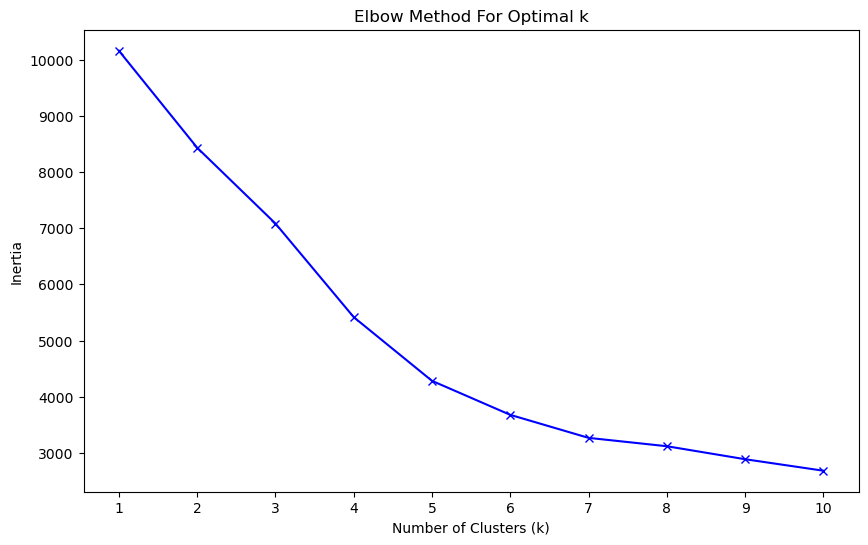

In [21]:
# Find optimal number of clusters using elbow method
inertias = []
n_clusters_range = range(1, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.xticks(n_clusters_range)
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

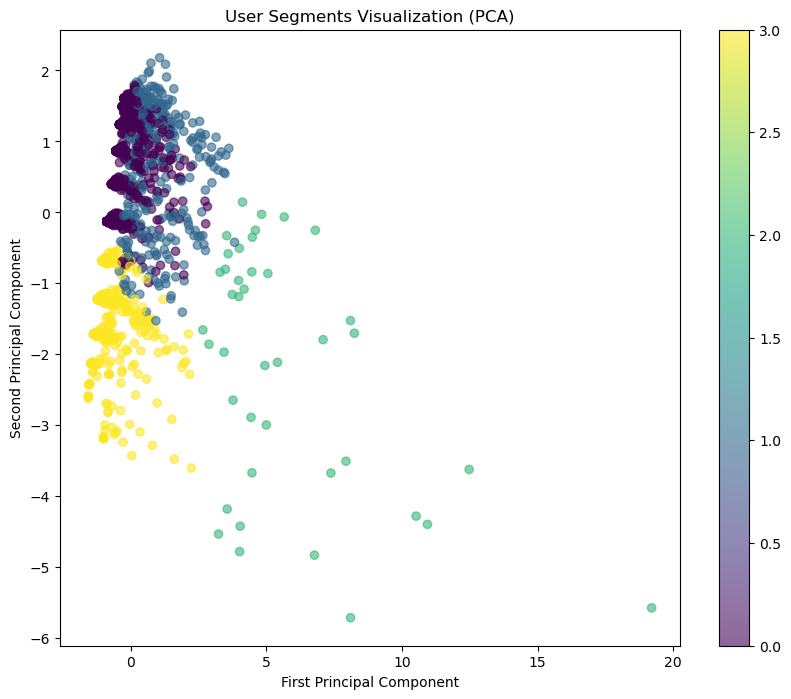

In [19]:
# Perform clustering with optimal number of clusters
n_clusters = 4  # Choose based on elbow curve
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clustering_data['cluster'] = kmeans.fit_predict(features_scaled)

# Analyze clusters
def analyze_clusters(data):
    # Calculate cluster characteristics
    cluster_stats = data.groupby('cluster').agg({
        'visit_total_time': 'mean',
        'visit_total_actions': 'mean',
        'visitor_returning': 'mean',
        'time_per_action': 'mean'
    })
    
    # Visualize clusters using PCA
    pca = PCA(n_components=2)
    coords = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], 
                         c=clustering_data['cluster'],
                         cmap='viridis', alpha=0.6)
    plt.title('User Segments Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.show()
    
    return cluster_stats

# Get cluster analysis
cluster_stats = analyze_clusters(clustering_data)

In [20]:
# Define and describe clusters
cluster_descriptions = {
    0: "Quick Browsers",
    1: "Engaged Researchers",
    2: "Regular Users",
    3: "Deep Divers"
}

print("\nUser Segment Characteristics:")
for cluster_id, description in cluster_descriptions.items():
    print(f"\nCluster {cluster_id} - {description}:")
    stats = cluster_stats.loc[cluster_id]
    print(f"- Average visit time: {stats['visit_total_time']:.1f} seconds")
    print(f"- Average actions per visit: {stats['visit_total_actions']:.1f}")
    print(f"- Returning visitor ratio: {stats['visitor_returning']*100:.1f}%")
    print(f"- Average time per action: {stats['time_per_action']:.1f} seconds")


User Segment Characteristics:

Cluster 0 - Quick Browsers:
- Average visit time: 434.4 seconds
- Average actions per visit: 12.2
- Returning visitor ratio: 80.4%
- Average time per action: 29.4 seconds

Cluster 1 - Engaged Researchers:
- Average visit time: 3757.0 seconds
- Average actions per visit: 36.5
- Returning visitor ratio: 97.6%
- Average time per action: 225.5 seconds

Cluster 2 - Regular Users:
- Average visit time: 9135.4 seconds
- Average actions per visit: 498.7
- Returning visitor ratio: 26.8%
- Average time per action: 21.9 seconds

Cluster 3 - Deep Divers:
- Average visit time: 805.4 seconds
- Average actions per visit: 17.7
- Returning visitor ratio: 84.2%
- Average time per action: 41.0 seconds


## 7. Summary and Recommendations

Based on our analysis, we can conclude:

1. Bot Traffic:
   - Percentage of automated traffic identified
   - Peak bot activity times
   - Common bot patterns

2. User Segments:
   - Quick Browsers: Brief visits, specific information seeking
   - Engaged Researchers: In-depth content exploration
   - Regular Users: Consistent patterns, returning visitors
   - Deep Divers: Long sessions, multiple page views

3. Key Insights:
   - Most popular entry points
   - Common user journeys
   - Peak usage times
   - Device preferences
